In [1]:
!echo $PYTHONPATH
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

%load_ext autoreload
%autoreload 2
%matplotlib ipympl

/usr/lib/python3.10/site-packages


In [2]:
from quilt.builder import NeuronCatalogue, SpikingNetwork

catalogue = NeuronCatalogue.from_yaml("tests/basal_ganglia_neurons.yaml")

Loaded model for neuron 'D1_neuron'

Loaded model for neuron 'D2_neuron'

Loaded model for neuron 'FSN_neuron'

Loaded model for neuron 'GPeTA_neuron'

Loaded model for neuron 'GPeTI_neuron'

Loaded model for neuron 'STN_neuron'

Loaded model for neuron 'SNR_neuron'

In [3]:
sn = SpikingNetwork.from_yaml("tests/basal_ganglia_network.yaml", catalogue)
sn.rescale_populations(0.5)
sn.rescale_connectivity(0.5)
sn.build()

Output()

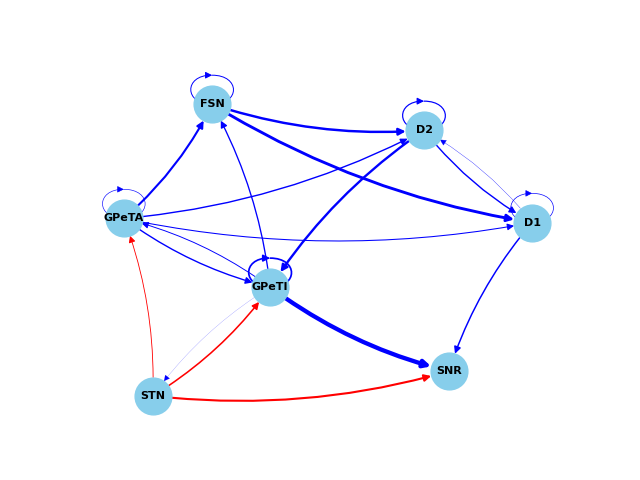

In [4]:
from quilt.view import plot_graph
fig, ax = plt.subplots()
plot_graph(sn)

In [5]:
pop_state_monitorized = "GPeTI"
for population in sn.populations.values():
    population.monitorize_spikes()
sn.populations[pop_state_monitorized].monitorize_states()

In [6]:
for pop in sn.populations.values():
    pop.add_injector(50, 0, 500)

sn.populations["D1"].add_injector(500,  # pA
                                  0,   # ms
                                  500   # ms
                                 )
sn.populations["D2"].add_injector(500,  # pA
                                  0,   # ms
                                  500   # ms
                                 )

In [7]:
# sn.run(dt=0.3, time=200)
sn.run(dt=0.1, time=500)

Running network consisting of 7311 neurons for 5000 timesteps

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Simulation took 9 s	(1.8444 ms/step)
	Gathering time avg: 35.63 us/step
	Inject time avg: 0.0164 us/step


In [8]:
spikes = dict()
for pop in sn.populations.keys():
    spikes[pop] = sn.populations[pop].get_data()['spikes']

states = sn.populations[pop_state_monitorized].get_data()['states']

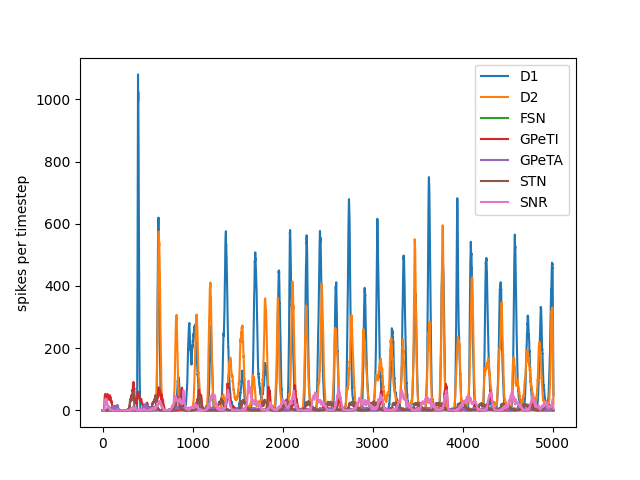

In [9]:
fig, ax = plt.subplots()
for pop in spikes.keys():
    N = 10
    
    plt.plot(np.convolve(spikes[pop], np.ones(N)), label=pop)
# plt.ylim(0,600)
plt.legend()
plt.ylabel("spikes per timestep");

D1 6.433333333333334
D2 6.4
FSN 0.0
GPeTI 6.066666666666666
GPeTA 21.4
STN 4.166666666666667
SNR 3.933333333333333


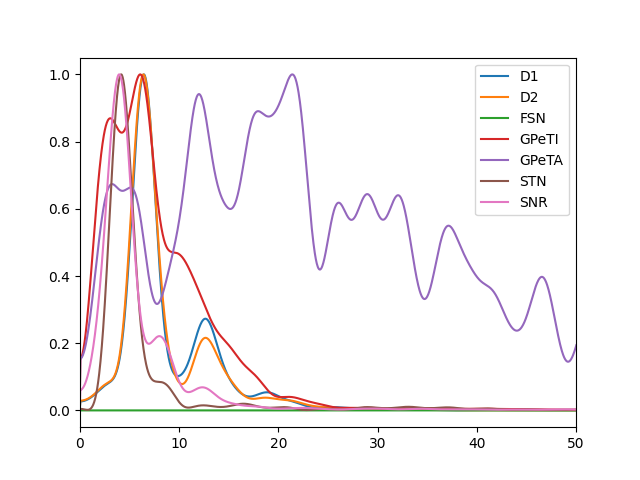

In [10]:
from numpy.fft import fft, fftfreq
from scipy.signal import welch
from sklearn.preprocessing import MinMaxScaler
fig, ax = plt.subplots()

pop = "D1"
burn_in = 2000
scaler = MinMaxScaler()
for pop in sn.populations.keys():
    signal = spikes[pop][burn_in:]
    N = len(spikes[pop])
    binned_signal = np.convolve(signal, np.ones(10))
    
    
    f, PSD = welch(binned_signal, 
                   1000, 
                   nperseg=500, 
                   noverlap=250,
                   nfft=30000, 
                   scaling='density', 
                   window='hamming')

    plt.plot(f, scaler.fit_transform(PSD[:, None]).squeeze(), label=pop)
    print(pop, f[np.argmax(PSD)])
plt.xlim([0,50]);
plt.legend();